In [4]:
!kaggle datasets download -d hashbanger/ph2-resized2

Dataset URL: https://www.kaggle.com/datasets/hashbanger/ph2-resized2
License(s): unknown
ph2-resized2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/ph2-resized2.zip'

# Directory where you want to extract the contents
extract_dir = '/content/data'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed!")


Extraction completed!


In [6]:
from keras.models import Model,Sequential
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [7]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [8]:
pwd

'/content'

In [9]:
file_list=sorted(glob.glob('/content/data/ph2_resized2/trainx/*.bmp'),key=numericalSort)
x_train=np.array([np.array(Image.open(fname)) for fname in file_list])
file_list_trainy=sorted(glob.glob('/content/data/ph2_resized2/trainy/*.bmp'),key=numericalSort)
y_train=np.array([np.array(Image.open(fname)) for fname in file_list_trainy])

In [10]:
x_train

array([[[[ 59,  55,  48],
         [ 58,  53,  47],
         [ 57,  54,  46],
         ...,
         [ 60,  54,  46],
         [ 62,  56,  47],
         [ 63,  57,  48]],

        [[ 65,  52,  50],
         [ 63,  50,  48],
         [ 59,  50,  46],
         ...,
         [ 65,  51,  50],
         [ 65,  51,  50],
         [ 67,  54,  52]],

        [[ 65,  54,  46],
         [ 65,  52,  46],
         [ 59,  49,  44],
         ...,
         [ 65,  50,  54],
         [ 66,  52,  54],
         [ 64,  53,  51]],

        ...,

        [[ 57,  42,  41],
         [ 57,  44,  40],
         [ 56,  44,  39],
         ...,
         [ 61,  46,  38],
         [ 59,  45,  39],
         [ 59,  48,  41]],

        [[ 44,  29,  24],
         [ 43,  29,  23],
         [ 42,  30,  23],
         ...,
         [ 47,  31,  25],
         [ 46,  30,  25],
         [ 45,  34,  27]],

        [[124, 117, 111],
         [124, 116, 112],
         [124, 117, 113],
         ...,
         [127, 118, 114],
        

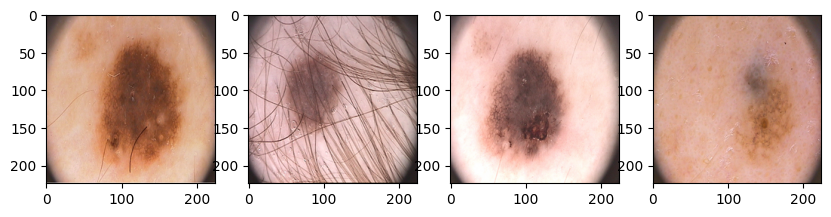

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,4,1)
plt.imshow(x_train[0])
plt.subplot(2,4,2)
plt.imshow(x_train[1])
plt.subplot(2,4,3)
plt.imshow(x_train[2])
plt.subplot(2,4,4)
plt.imshow(x_train[3])


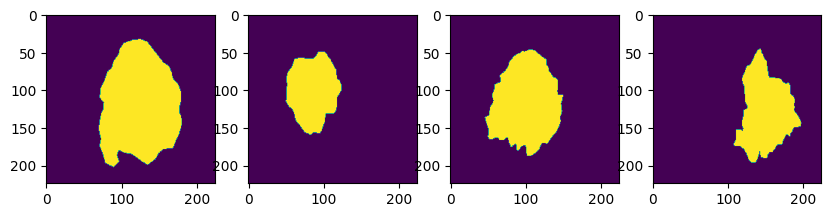

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(2,4,1)
plt.imshow(y_train[0])
plt.subplot(2,4,2)
plt.imshow(y_train[1])
plt.subplot(2,4,3)
plt.imshow(y_train[2])
plt.subplot(2,4,4)
plt.imshow(y_train[3])


In [13]:
import tensorflow.keras.backend as K
import tensorflow.keras.backend as K
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [15]:
def precision(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)  # Cast y_pred to float32
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32 to match y_pred
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [16]:
def recall(y_true, y_pred):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [17]:
def accuracy(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')  # Cast y_true to float32
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [18]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [19]:
def img_agumentation(x_train,y_train):
  x_rotat=[]
  y_rotat=[]
  x_flip=[]
  y_flip=[]
  for i in range(len(x_train)):
    x,y=random_rotation(x_train[i],y_train[i])
    x_rotat.append(x)
    y_rotat.append(y)
    x,y=horizontal_flip(x_train[i],y_train[i])
    x_flip.append(x)
    y_flip.append(y)
  return np.array(x_rotat),np.array(y_rotat),np.array(x_flip),np.array(y_flip)

In [20]:
'''
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)
    '''

'\ndef img_augmentation(x_test, y_test):\n    x_rotat = []\n    y_rotat = []\n    x_flip = []\n    y_flip = []\n    x_nois = []\n    for idx in range(len(x_test)):\n        x,y = random_rotation(x_test[idx], y_test[idx])\n        x_rotat.append(x)\n        y_rotat.append(y)\n\n        x,y = horizontal_flip(x_test[idx], y_test[idx])\n        x_flip.append(x)\n        y_flip.append(y)\n\n    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)\n    '

In [21]:
x_roated,y_roated,x_fliped,y_fliped=img_agumentation(x_train,y_train)

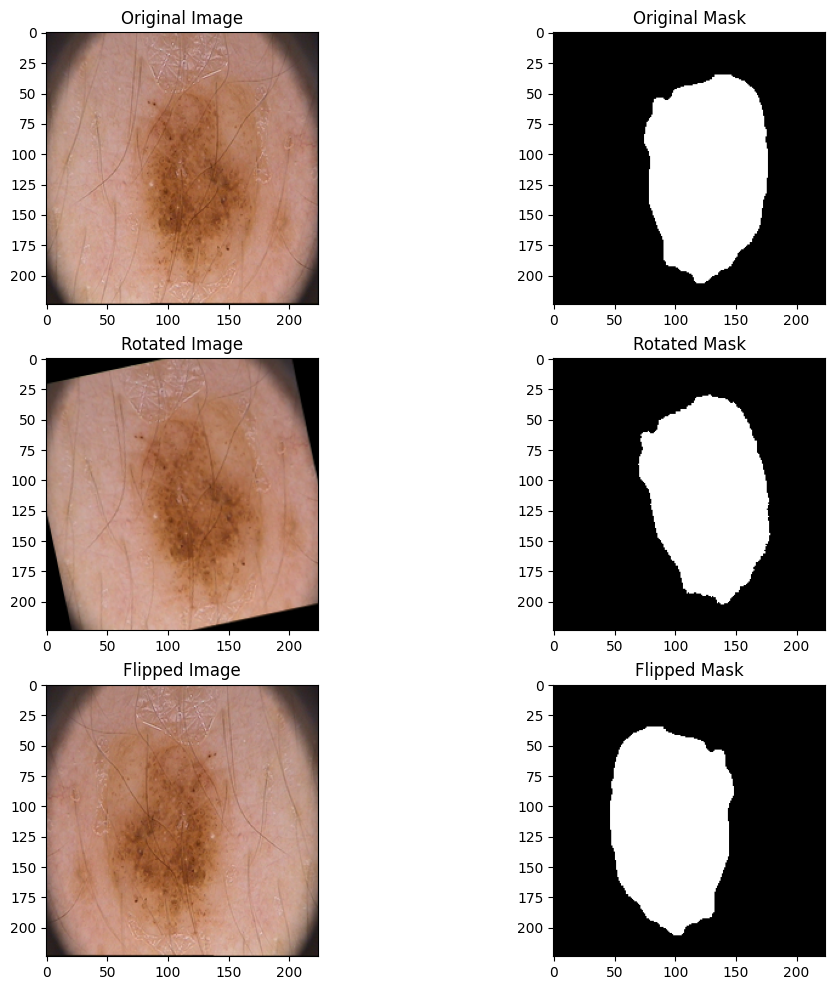

In [22]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_roated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_roated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_fliped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_fliped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [23]:
x_train_full=np.concatenate((x_train,x_roated,x_fliped))
y_train_full=np.concatenate((y_train,y_roated,y_fliped))

In [24]:
x_train,x_test,y_train,y_test=train_test_split(x_train_full,y_train_full,test_size=0.30,random_state=2)

In [25]:
x_train.shape

(420, 224, 224, 3)

In [26]:
def unet(epochs_num,savename):

    # Encoding layer
    img_input = Input(shape= (224,224,3))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((224,224))(x)

    model = Model(inputs=img_input, outputs=pred)

    model.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_test,y_test), verbose=1)

    model.save(savename)
    return model,hist

In [27]:
model,hist=unet(40,savename='Second_model.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 224, 224, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 224, 224, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 112, 112, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 112, 112, 128)       │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv2D)                       │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv6 (Conv2D)                       │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn6 (BatchNormalization)             │ (None, 56, 56, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4965 - dice_coef: 0.4092 - iou: 0.6887 - loss: 0.7483 - precision: 0.3521 - recall: 0.6427 - val_accuracy: 0.6880 - val_dice_coef: 0.3746 - val_iou: 0.7050 - val_loss: 0.6766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 56s 781ms/step - accuracy: 0.7303 - dice_coef: 0.4935 - iou: 0.7613 - loss: 0.5751 - precision: 0.5663 - recall: 0.7775 - val_accuracy: 0.6880 - val_dice_coef: 0.3519 - val_iou: 0.7184 - val_loss: 0.6448 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 794ms/step - accuracy: 0.8413 - dice_coef: 0.5468 - iou: 0.8087 - loss: 0.4747 - precision: 0.7355 - recall: 0.8112 - val_accuracy: 0.6880 - val_dice_coef: 0.3289 - val_iou: 0.7273 - val_loss: 0.6290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 759ms/step - accuracy: 0.8775 - dice_coef: 0.5706 - iou: 0.8285 - loss: 0.4

In [28]:
model.evaluate(x_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step - accuracy: 0.9439 - dice_coef: 0.7734 - iou: 0.9400 - loss: 0.1986 - precision: 0.9538 - recall: 0.8679


[0.19952447712421417,
 0.9390532374382019,
 0.7652647495269775,
 0.9487482905387878,
 0.8631959557533264,
 0.943065881729126]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


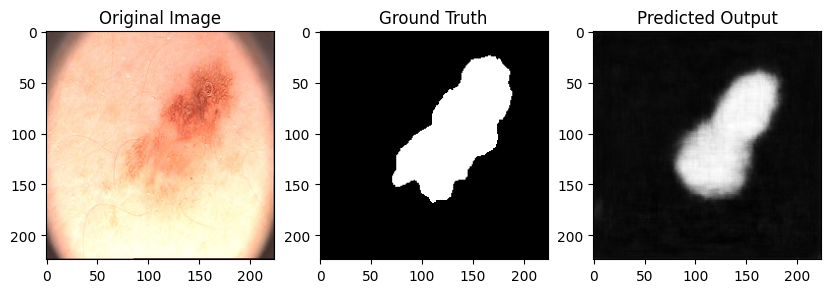

In [29]:
img_num = 1
img_pred = model.predict(x_test[img_num].reshape(1,224,224,3)) # Changed 244 to 224 to match image dimensions
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r) # You might need to adjust this reshape based on your model output
plt.title('Predicted Output')
plt.show()

In [32]:
def enhance(img):
    sub = (model.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


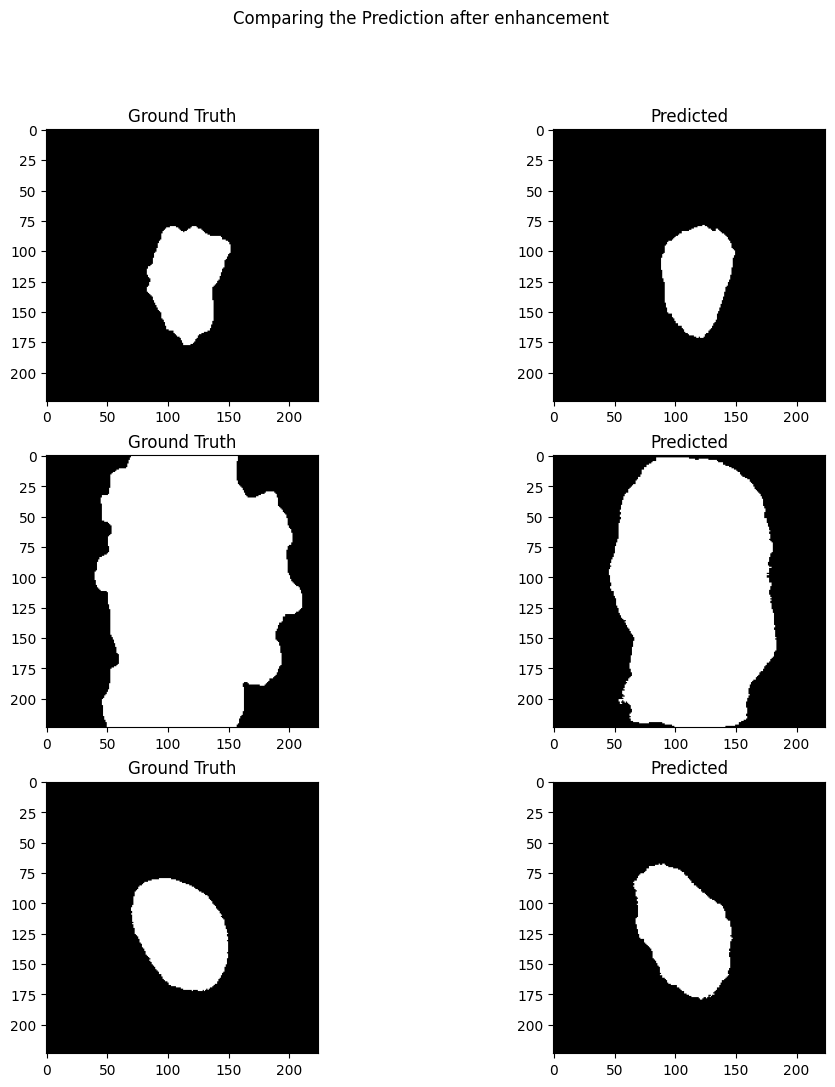

In [33]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()